In [ ]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from time import sleep
from hydro_serving_grpc.reqstore import reqstore_client

import hydro_serving_grpc as hs_grpc
from client import HydroServingClient, HydroServingServable, HydroServingModel

In [40]:
hs_client = HydroServingClient("localhost:9090")

In [41]:
mnist_model = hs_client.get_model("mnist", 1)

In [117]:
# Check hello from rootcause service
requests.get("http://localhost/rootcause/").text

'hydro_root_cause_service'

In [43]:
import mnist
images = mnist.train_images()

Plot random image

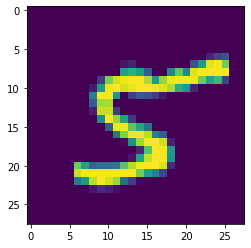

In [44]:
x = images[np.random.randint(0, images.shape[0])]
plt.imshow(x)

Send data to reqstore

In [45]:
mnist_servable = hs_client.deploy_servable("mnist", 1)
for _ in tqdm(range(10)):
    sleep(0.2)
    x = images[np.random.randint(0, images.shape[0])].reshape((1, 28, 28))
    x = x / 255.
    mnist_servable(x, _profile=True)
mnist_servable.delete()

2019-07-30 15:13:09.110 | INFO     | client:deploy_servable:76 - mnist-1-fluffy-parallax is ServableStatus.STARTING
2019-07-30 15:13:14.030 | INFO     | client:deploy_servable:76 - mnist-1-fluffy-parallax is ServableStatus.SERVING


Check that data is in the reqstore

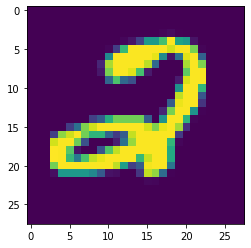

In [46]:
rs_client = reqstore_client.ReqstoreClient("localhost:9090", insecure=True)
subsample = list(rs_client.subsampling("1", 10))
image = list(mnist_model.contract.decode_request(subsample[0].entries[0].request).values())[0]
plt.imshow(image[0])

Fetch reqstore descriptors about this image

In [47]:
folder = mnist_model.id
ts = subsample[0].ts
uid = subsample[0].entries[0].uid

Check reqstore again

In [48]:
r = rs_client.get(str(folder), ts, uid)
r

TsRecord(ts=1564488796200, entries=[Entry(uid=18)])

Send model description and exlained instance description to rootcause

In [58]:
r = requests.post("http://localhost/rootcause/rise", json={"model":{"name":"mnist", "version":1},
                                                      "explained_instance":{"timestamp":ts, "uid": uid}})


In [59]:
r.text

'{}\n'

In [60]:
redirect_url = r.headers['Location']
print(redirect_url)
requests.get(redirect_url).text

http://localhost/rootcause/status/rise/0701519c-545a-48ee-9a63-95f12a99ca84


'{\n  "state": "PENDING"\n}\n'

In [68]:
requests.get(redirect_url).text

'{\n  "result": "5d40347868b663a1b4261539", \n  "state": "SUCCESS"\n}\n'

In [79]:
import json
import ast

result_id = requests.get(redirect_url).json()['result']
result = requests.get(f"http://localhost/rootcause/fetch_result/rise/{result_id}")
result_response = result.json()
result_response

{'completed_at': 'Tue, 30 Jul 2019 12:13:53 GMT',
 'created_at': 'Tue, 30 Jul 2019 12:13:44 GMT',
 'explained_instance': {'timestamp': 1564488796200, 'uid': 18},
 'model': {'name': 'mnist', 'version': 1},
 'result': {'masks': '[[[7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7, 7, 7], [7, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 7, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 7, 7, 7, 7], [8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7

In [80]:
masks = np.array(ast.literal_eval(result_response['result']['masks']))

Masks is an array of shape (number of classes, width, heigh). It can be seen as a collection of masks of shape (width, height), one for each class, which show which parts of images activate that particular class.

In [81]:
masks.shape 

(10, 28, 28)

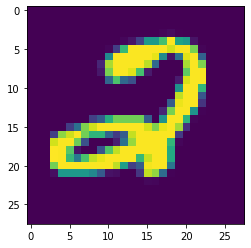

In [94]:
request = rs_client.get(str(folder), ts, uid).entries[0].request
x = mnist_model.contract.decode_request(request)['input']
# Original image from reqstore
plt.imshow(x[0])

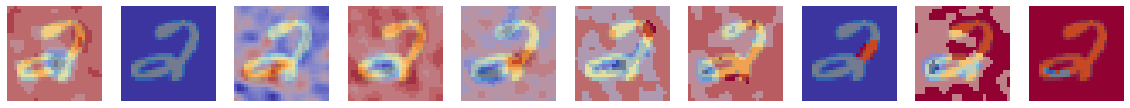

In [116]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(20, 5)
for i in range(10):
    axes[i].imshow(x[0])
    axes[i].imshow(masks[i]/255., alpha = 0.7, cmap = "coolwarm")
    axes[i].axis("off")